### 1. Loading the data and exploratory data analysis of metadata

## Imports and loading the data

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import transforms, models
from PIL import Image as PILImage
from tqdm import tqdm
import torchvision.models as models
import time
import random

from google.colab import drive
drive.mount('/content/drive')

# load the appropriate directory on Google Drive
!rm -f data
!ln -s '/content/drive/My Drive/4-1/petfinder-pawpularity-score' data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pretrainedmodels
import pretrainedmodels

     |████████████████████████████████| 58 kB 3.0 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=257cfa430b7d545d1ff85a48ceb03b88fa03d821c71a08ef8d7aba55b6b20e6e
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


## Load train and test metadata

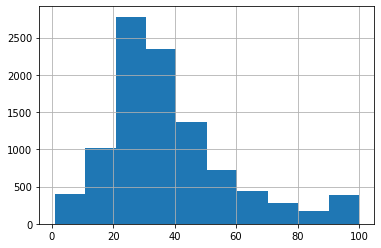

In [4]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_train["Pawpularity"].hist()

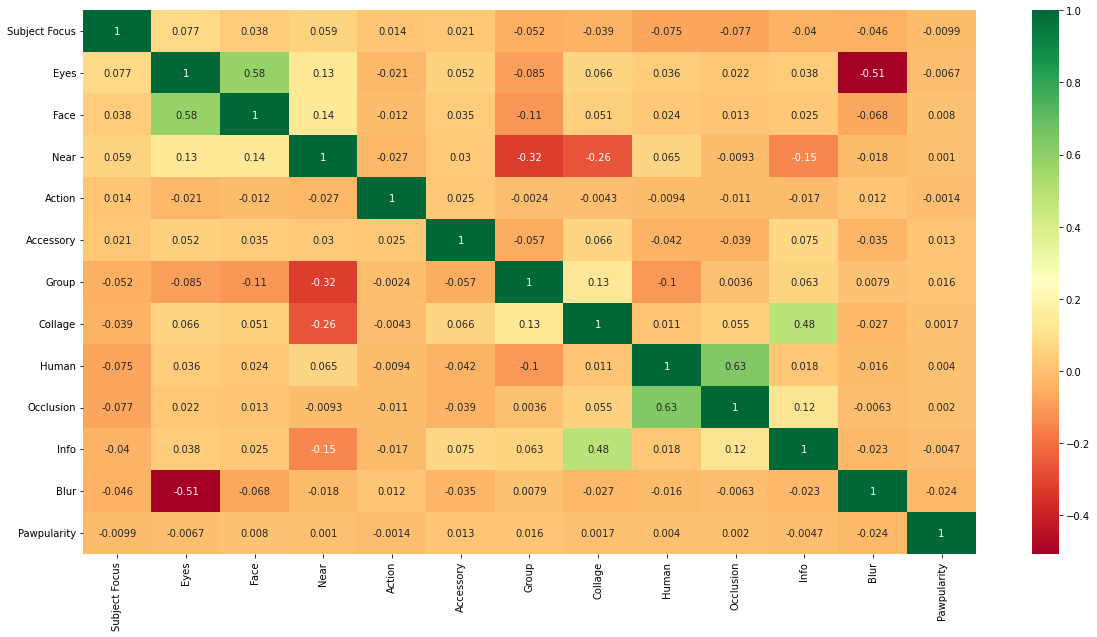

In [5]:
sns.heatmap(df_train.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

Id               fff8e47c766799c9e12f3cb3d66ad228
Subject Focus                                   1
Eyes                                            1
Face                                            1
Near                                            1
Action                                          1
Accessory                                       1
Group                                           1
Collage                                         1
Human                                           1
Occlusion                                       1
Info                                            1
Blur                                            1
Pawpularity                                   100
dtype: object
Id               0007de18844b0dbbb5e1f607da0606e0
Subject Focus                                   0
Eyes                                            0
Face                                            0
Near                                            0
Action                              

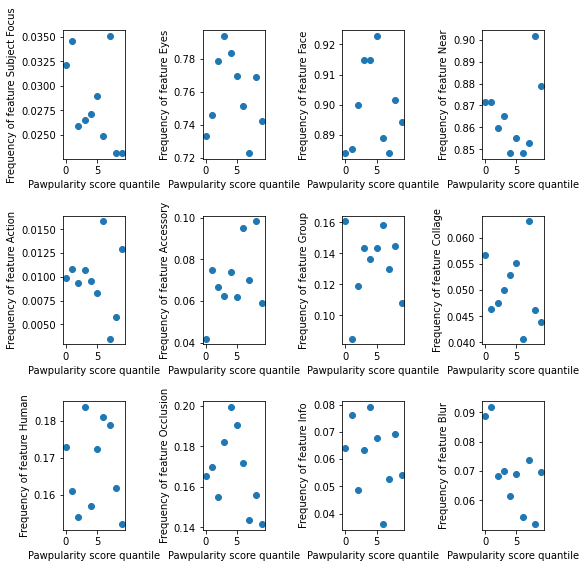

In [6]:
# verify no values outside of [0, 1]
print(df_train.max(axis=0))
print(df_train.min(axis=0))

by_features = [[], [], [], [], [], [], [], [], [], [], [], []]

for i in range(10):
    df_x = df_train[df_train["Pawpularity"] <= 10*(i+1)]
    df_x = df_x[df_x["Pawpularity"] > 10*(i)]
    df_x = df_x.drop(columns=['Id','Pawpularity'])
    for colnum, col in enumerate(df_train.columns):
        if col=="Id" or col=="Pawpularity":
           continue
        #print(f'Proportion of those that have have feature {col} = 1 and pawpularity score between {i*10+1} and {(i+1)*10} is {np.sum(df_x[col].values)/df_x[col].values.shape[0]}')
        by_features[colnum-1].append(
            np.sum(df_x[col].values)/df_x[col].values.shape[0]
        )

fig = plt.figure(figsize=(8,8))
for colnum, col in enumerate(df_train.columns):
    if col=="Id" or col=="Pawpularity":
        continue
    fig.add_subplot(3,4,colnum)
    plt.scatter(np.arange(0,10), by_features[colnum-1])
    fig.get_axes()[colnum-1].set_ylabel("Frequency of feature {}" .format(col))
    fig.get_axes()[colnum-1].set_xlabel("Pawpularity score quantile")

plt.tight_layout()

In [7]:
df_train.isnull().sum() # no missing values!

Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
Pawpularity      0
dtype: int64

In [8]:
# calculate VIF for each predictor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

metadata_columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

vif_data = pd.DataFrame()
vif_data["feature"] = df_train[metadata_columns].columns
vif_data["VIF"] = [variance_inflation_factor(df_train[metadata_columns].values, i) for i in range(len(metadata_columns))]
vif_data

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,feature,VIF
0,Subject Focus,1.048292
1,Eyes,10.118170
2,Face,13.715668
3,Near,5.762924
4,Action,1.010174
5,Accessory,1.090942
6,Group,1.163850
7,Collage,1.452023
8,Human,2.064939
9,Occlusion,2.073562


Text(0, 0.5, 'cumulative explained variance')

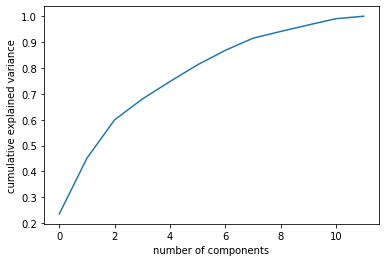

In [9]:
# principal component analysis
from sklearn.decomposition import PCA
pca = PCA().fit(df_train[metadata_columns].values)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Both our PCA and VIF tests seem to suggest that not all 12 predictors are required - there is evidence of at least some multicollinearity (since the VIF for 'Eyes' and 'Face' both exceed 10.) PCA also suggests that 9 features could preserve over >90% of the variance, so let's try to remove feature 'Eyes' since that also has strong negative correlation with 'Blur' according to the correlation heatmap.

Let's now attempt to fit a variety of models to our data. Since our desired output is constrained to the range $[1,100]$ and we have sufficient datapoints for each pawpularity score $\{1,...,100\}$, we can use the logistic regression model (treating the problem as 100-class classification).

We can also use the standard linear regression and ElasticNet models (ElasticNet is just linear regression with L1-norm and L2-norm regularizers) although there is no constraint that specifies the output must fall within $[0,100]$.

Finally, we attempt to fit some non-linear models to the data, such as Random Forest Regressor and Decision Tree Regressor, and check if Random Forest Regressor can provide better estimates than Decision Tree Regressor.


### 2. Experimentation with linear models

In [10]:
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz
from IPython.display import Image

df_train_from_csv = df_train.drop(columns=['Id','Eyes','Pawpularity'])
df_train_labels = df_train["Pawpularity"]

mean_cv = 0
CHOSEN_NUM_SPLITS = 5

kf = KFold(n_splits=CHOSEN_NUM_SPLITS, random_state=1001, shuffle=True)
print("** LOGISTIC REGRESSION **")
for train_index, val_index in kf.split(df_train_from_csv):
    lr_model = LogisticRegression(penalty='l2', solver='liblinear')
    t = list(train_index)
    v = list(val_index)
    lr_model.fit(df_train_from_csv.iloc[t].values, df_train_labels.iloc[t].values)
    lr_pred = lr_model.predict(df_train_from_csv.iloc[v].values)
    rmse_this_fold = mean_squared_error(df_train_labels.iloc[v].values, lr_pred, squared=False)
    print(f'RMSE: {rmse_this_fold}')
    mean_cv += rmse_this_fold

print(f'{CHOSEN_NUM_SPLITS}-fold mean RMSE: {mean_cv/CHOSEN_NUM_SPLITS}')

** LOGISTIC REGRESSION **
RMSE: 22.07273768397014
RMSE: 26.392131959155375
RMSE: 22.84638076427503
RMSE: 23.143772550533708
RMSE: 22.47746937862452
5-fold mean RMSE: 23.386498467311753


In [11]:
mean_cv = 0
print("** LINEAR REGRESSION **")
for train_index, val_index in kf.split(df_train_from_csv):
    lr_model = LinearRegression()
    t = list(train_index)
    v = list(val_index)
    lr_model.fit(df_train_from_csv.iloc[t].values, df_train_labels.iloc[t].values)
    lr_pred = lr_model.predict(df_train_from_csv.iloc[v].values)
    rmse_this_fold = mean_squared_error(df_train_labels.iloc[v].values, lr_pred, squared=False)
    print(f'RMSE: {rmse_this_fold}')
    mean_cv += rmse_this_fold

print(f'{CHOSEN_NUM_SPLITS}-fold mean RMSE: {mean_cv/CHOSEN_NUM_SPLITS}')

** LINEAR REGRESSION **
RMSE: 20.497054128957323
RMSE: 20.798991972721534
RMSE: 19.676767950320055
RMSE: 21.11559863589002
RMSE: 20.913044799098046
5-fold mean RMSE: 20.600291497397397


In [12]:
mean_cv = 0
print("** ELASTICNET REGRESSION **")
for train_index, val_index in kf.split(df_train_from_csv):
    lr_model = ElasticNet(random_state=612)
    t = list(train_index)
    v = list(val_index)
    lr_model.fit(df_train_from_csv.iloc[t].values, df_train_labels.iloc[t].values)
    lr_pred = lr_model.predict(df_train_from_csv.iloc[v].values)
    rmse_this_fold = mean_squared_error(df_train_labels.iloc[v].values, lr_pred, squared=False)
    print(f'RMSE: {rmse_this_fold}')
    mean_cv += rmse_this_fold

print(f'{CHOSEN_NUM_SPLITS}-fold mean RMSE: {mean_cv/CHOSEN_NUM_SPLITS}')

** ELASTICNET REGRESSION **
RMSE: 20.472768982673145
RMSE: 20.79338151400813
RMSE: 19.673848419668925
RMSE: 21.10813591218607
RMSE: 20.89543104166644
5-fold mean RMSE: 20.588713174040542


In [13]:
mean_cv = 0
print("** DECISION TREE REGRESSOR **")
# create a decision tree regressor model 
for train_index, val_index in kf.split(df_train_from_csv):
    dtr_model = DecisionTreeRegressor(random_state=689)
    t = list(train_index)
    v = list(val_index)
    dtr_model.fit(df_train_from_csv.iloc[t].values, df_train_labels.iloc[t].values)
    dtr_pred = dtr_model.predict(df_train_from_csv.iloc[v].values)
    rmse_this_fold = mean_squared_error(df_train_labels.iloc[v].values, dtr_pred, squared=False)
    print(f'RMSE: {rmse_this_fold}')
    mean_cv += rmse_this_fold

print(f'{CHOSEN_NUM_SPLITS}-fold mean RMSE: {mean_cv/CHOSEN_NUM_SPLITS}')

export_graphviz(dtr_model, out_file = 'data/tree.dot', feature_names=df_train_from_csv.columns)
with open('data/tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

import pydot

(graph,) = pydot.graph_from_dot_file('data/tree.dot')
graph.write_png('data/tree.png') # save the tree as png since hard to read in Colab output

** DECISION TREE REGRESSOR **
RMSE: 20.85086775207827
RMSE: 21.096591503505856
RMSE: 19.796969683275222
RMSE: 21.337460992011668
RMSE: 21.189394890016672
5-fold mean RMSE: 20.854256964177537


In [14]:
from sklearn.model_selection import GridSearchCV

dtr_model = DecisionTreeRegressor(max_leaf_nodes=20, random_state=689)
tuned_parameters = {'ccp_alpha': np.logspace(-6, -1, 50)}
# search the parameter space with cross-validation
n_folds = 5
regressor = GridSearchCV(dtr_model, tuned_parameters, cv=n_folds, scoring='neg_mean_squared_error')
regressor.fit(df_train_from_csv.values, df_train_labels.values)

cv_result = pd.DataFrame(regressor.cv_results_)
cv_result.sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
49,0.003334,0.000152,0.000533,0.000027,0.1,{'ccp_alpha': 0.1},-432.089033,-434.639847,-441.08798,-406.724725,-418.097818,-426.527880,12.425440,1
48,0.003333,0.000204,0.000504,0.000018,0.0790604,{'ccp_alpha': 0.07906043210907701},-432.089033,-435.075472,-441.08798,-406.619078,-418.086550,-426.591623,12.518629,2
37,0.003647,0.000540,0.000564,0.000065,0.00596362,{'ccp_alpha': 0.005963623316594642},-432.089033,-435.075472,-441.08798,-406.621133,-418.086550,-426.592034,12.517974,3
27,0.004077,0.001068,0.000630,0.000176,0.000568987,{'ccp_alpha': 0.0005689866029018299},-432.089033,-435.075472,-441.08798,-406.621133,-418.086550,-426.592034,12.517974,3
28,0.003318,0.000158,0.000534,0.000038,0.000719686,{'ccp_alpha': 0.0007196856730011522},-432.089033,-435.075472,-441.08798,-406.621133,-418.086550,-426.592034,12.517974,3
29,0.003385,0.000186,0.000494,0.000008,0.000910298,{'ccp_alpha': 0.0009102981779915217},-432.089033,-435.075472,-441.08798,-406.621133,-418.086550,-426.592034,12.517974,3
30,0.003350,0.000177,0.000562,0.000109,0.0011514,{'ccp_alpha': 0.0011513953993264481},-432.089033,-435.075472,-441.08798,-406.621133,-418.086550,-426.592034,12.517974,3
31,0.003580,0.000674,0.000505,0.000009,0.00145635,{'ccp_alpha': 0.0014563484775012444},-432.089033,-435.075472,-441.08798,-406.621133,-418.086550,-426.592034,12.517974,3
32,0.003402,0.000301,0.000500,0.000019,0.00184207,{'ccp_alpha': 0.0018420699693267163},-432.089033,-435.075472,-441.08798,-406.621133,-418.086550,-426.592034,12.517974,3
33,0.003783,0.000812,0.000514,0.000018,0.00232995,{'ccp_alpha': 0.002329951810515372},-432.089033,-435.075472,-441.08798,-406.621133,-418.086550,-426.592034,12.517974,3


{'ccp_alpha': 0.1}
** DECISION TREE REGRESSOR (PRUNED) **
RMSE: 20.583556897491583
RMSE: 20.834792614714107
RMSE: 19.73292093310384
RMSE: 21.133487128647815
RMSE: 21.044836762223667
5-fold mean RMSE: 20.665918867236204


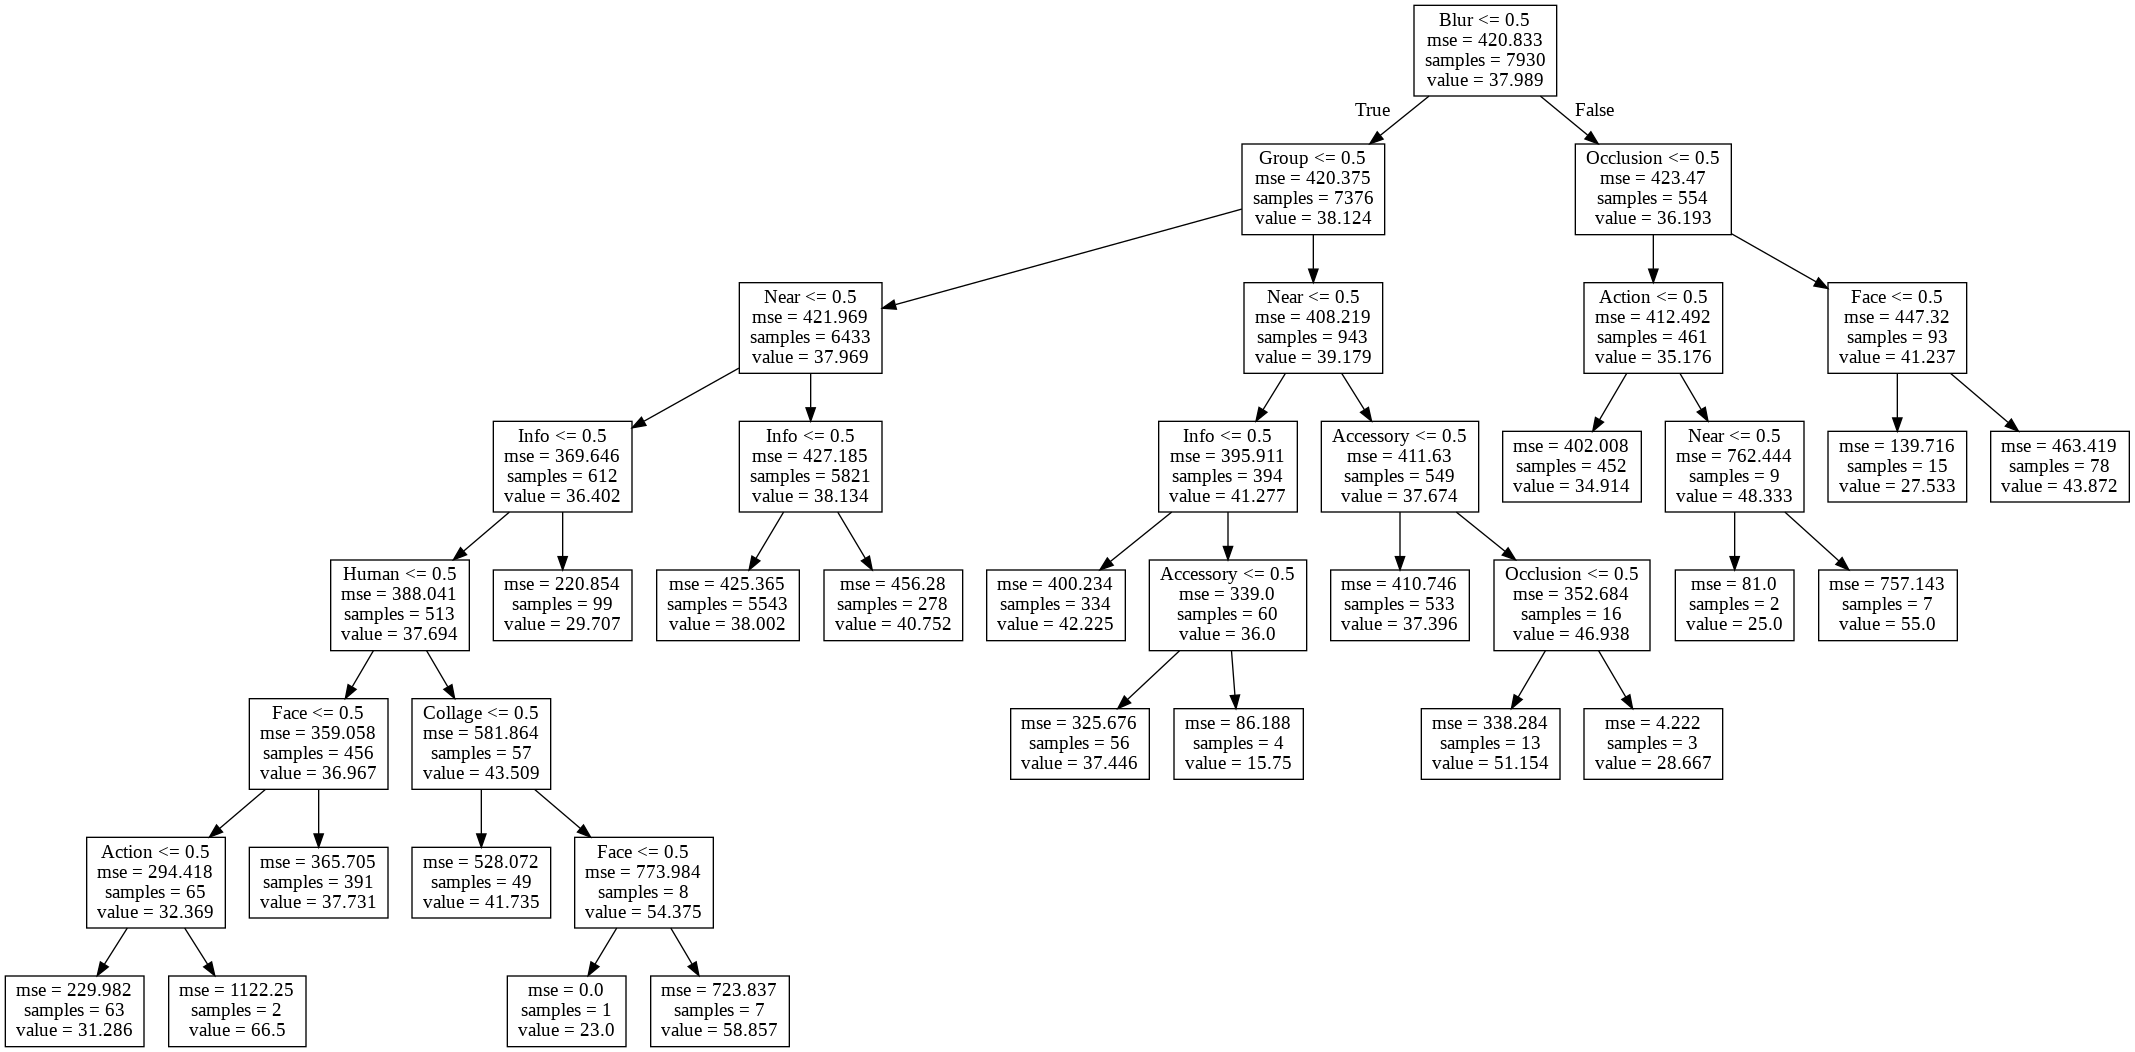

In [15]:
# Choose the best CV parameters for pruning
print(regressor.best_params_)
best_regr = regressor.best_estimator_

mean_cv = 0
print("** DECISION TREE REGRESSOR (PRUNED) **")
# create a pruned decision tree regressor model 
for train_index, val_index in kf.split(df_train_from_csv):
    dtr_model = best_regr
    t = list(train_index)
    v = list(val_index)
    dtr_model.fit(df_train_from_csv.iloc[t].values, df_train_labels.iloc[t].values)
    dtr_pred = dtr_model.predict(df_train_from_csv.iloc[v].values)
    rmse_this_fold = mean_squared_error(df_train_labels.iloc[v].values, dtr_pred, squared=False)
    print(f'RMSE: {rmse_this_fold}')
    mean_cv += rmse_this_fold

print(f'{CHOSEN_NUM_SPLITS}-fold mean RMSE: {mean_cv/CHOSEN_NUM_SPLITS}')

# UNUSED
# we use the value with the highest mean_test_score, but find that alpha≥0.24 already causes the image to reduce to the one-node estimator
# so we use the value with the highest mean_test_score until we get an acceptably low alpha, which in this case is 0.145635
#best_regr = DecisionTreeRegressor(ccp_alpha=0.145635, random_state=689)
#best_regr.fit(df_train_from_csv.values, df_train_labels.values)

export_graphviz(best_regr, out_file = 'data/pruned_tree.dot', feature_names=df_train_from_csv.columns)
with open('data/pruned_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

#import pydot

#(graph,) = pydot.graph_from_dot_file('data/pruned_tree.dot')
#graph.write_png('data/pruned_tree.png') # save the tree as png since hard to read in Colab output

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

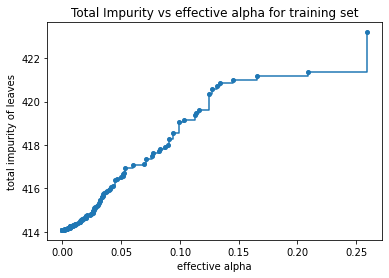

In [16]:
regr = DecisionTreeRegressor(random_state=689)
# Compute the pruning path during Minimal Cost-Complexity Pruning.
path = regr.cost_complexity_pruning_path(df_train_from_csv.values, df_train_labels.values)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post", markersize=4)
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [17]:
mean_cv = 0
print("** RANDOM FOREST REGRESSOR **")
# create a random forest regressor model with DecisionTreeRegressor as base estimator
for train_index, val_index in kf.split(df_train_from_csv):
    rfr_model = RandomForestRegressor(n_estimators=100, oob_score=True, bootstrap=True, random_state=777)
    t = list(train_index)
    v = list(val_index)
    rfr_model.fit(df_train_from_csv.iloc[t].values, df_train_labels.iloc[t].values)
    rfr_pred = rfr_model.predict(df_train_from_csv.iloc[v].values)
    rmse_this_fold = mean_squared_error(df_train_labels.iloc[v].values, rfr_pred, squared=False)
    print(f'RMSE: {rmse_this_fold}')
    mean_cv += rmse_this_fold

print(f'{CHOSEN_NUM_SPLITS}-fold mean RMSE: {mean_cv/CHOSEN_NUM_SPLITS}')

** RANDOM FOREST REGRESSOR **
RMSE: 20.680950187047415
RMSE: 21.027632130554117
RMSE: 19.756694584708587
RMSE: 21.254126820075157
RMSE: 21.097397361191803
5-fold mean RMSE: 20.763360216715416


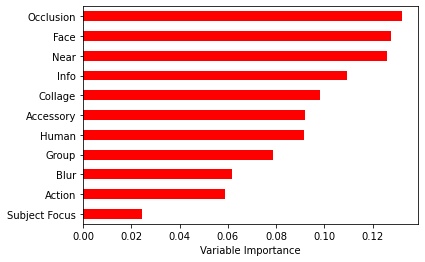

In [18]:
importances = pd.DataFrame({'Importance': rfr_model.feature_importances_}, index=df_train_from_csv.columns)
importances.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [19]:
importances_list = importances.sort_values('Importance',ascending=True).index.values
print(importances_list)

['Subject Focus' 'Action' 'Blur' 'Group' 'Human' 'Accessory' 'Collage'
 'Info' 'Near' 'Face' 'Occlusion']


In [20]:
rf_scores_array = []
#print(df_train_from_csv.columns)

print("** RANDOM FOREST REGRESSOR (BACKWARD SUBSET) **")
# create a random forest regressor model with DecisionTreeRegressor as base estimator
for i in range(0, len(importances_list)-5): # keep the 5 most important features
    rf_scores_for_subset = []
    mean_cv = 0
    for train_index, val_index in kf.split(df_train_from_csv):
        rfr_model = RandomForestRegressor(n_estimators=100, oob_score=True, bootstrap=True, random_state=777)
        t = list(train_index)
        v = list(val_index)
        df_train_refined = df_train_from_csv.drop(columns=importances_list[:i+1], axis=1) # make new df only containing non-dropped columns
        rfr_model.fit(df_train_refined.iloc[t].values, df_train_labels.iloc[t].values)
        rfr_pred = rfr_model.predict(df_train_refined.iloc[v].values)
        rmse_this_fold = mean_squared_error(df_train_labels.iloc[v].values, rfr_pred, squared=False)
        mean_cv += rmse_this_fold
        rf_scores_for_subset.append(rmse_this_fold)
    
    print(f'index {i} has {CHOSEN_NUM_SPLITS}-fold mean RMSE: {mean_cv/CHOSEN_NUM_SPLITS}')
    rf_scores_array.append(rf_scores_for_subset)


** RANDOM FOREST REGRESSOR (BACKWARD SUBSET) **
index 0 has 5-fold mean RMSE: 20.76518781528319
index 1 has 5-fold mean RMSE: 20.747997323169187
index 2 has 5-fold mean RMSE: 20.727040138016495
index 3 has 5-fold mean RMSE: 20.682105728475257
index 4 has 5-fold mean RMSE: 20.65610995534115
index 5 has 5-fold mean RMSE: 20.63021723107601


In [21]:
mean_cv = 0
for train_index, val_index in kf.split(df_train_from_csv):
    rfr_model = RandomForestRegressor(n_estimators=100, oob_score=True, bootstrap=True, random_state=777)
    t = list(train_index)
    v = list(val_index)
    df_train_refined = df_train_from_csv.drop(columns=importances_list[:5+1], axis=1) # make new df only containing non-dropped columns
    rfr_model.fit(df_train_refined.iloc[t].values, df_train_labels.iloc[t].values)
    rfr_pred = rfr_model.predict(df_train_refined.iloc[v].values)
    rmse_this_fold = mean_squared_error(df_train_labels.iloc[v].values, rfr_pred, squared=False)
    mean_cv += rmse_this_fold

print(f'RF subset has {CHOSEN_NUM_SPLITS}-fold mean RMSE: {mean_cv/CHOSEN_NUM_SPLITS}')

RF subset has 5-fold mean RMSE: 20.63021723107601


In [22]:
!pip install mord
import mord as mord

  Created wheel for mord: filename=mord-0.6-py3-none-any.whl size=6006 sha256=ee48d00d461f6e02e9f8281fd3d42a7579d161a1cf84b7ac5590818383517fe7
  Stored in directory: /root/.cache/pip/wheels/80/1d/8a/bef1a01b6a3c91494905d161d5426c181819f9730a773141eb
Successfully built mord


In [23]:
mean_cv = 0
print("** ORDINAL RIDGE REGRESSION **")
# create a ordinal regressor model
for train_index, val_index in kf.split(df_train_from_csv):
    ordinal_regr_model = mord.OrdinalRidge()
    t = list(train_index)
    v = list(val_index)
    ordinal_regr_model.fit(df_train_from_csv.iloc[t].values, df_train_labels.iloc[t].values)
    ordinal_regr_pred = ordinal_regr_model.predict(df_train_from_csv.iloc[v].values)
    rmse_this_fold = mean_squared_error(df_train_labels.iloc[v].values, ordinal_regr_pred, squared=False)
    print(f'RMSE: {rmse_this_fold}')
    mean_cv += rmse_this_fold

print(f'{CHOSEN_NUM_SPLITS}-fold mean RMSE: {mean_cv/CHOSEN_NUM_SPLITS}')

** ORDINAL RIDGE REGRESSION **
RMSE: 20.494492083212634
RMSE: 20.79454280791033
RMSE: 19.680623528799615
RMSE: 21.12027686498648
RMSE: 20.913509362724923
5-fold mean RMSE: 20.600688929526797


## Define custom PawpularityDataset for ease of getting items

In [24]:
# list of metadata columns
metadata_columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

EFFICIENTNET_IMAGE_SIZE = (224, 224)

# get a list of all file paths for each training and testing sample
train_file_paths = []
test_file_paths = []
root_train_path = "data/train"
root_test_path = "data/test"

for file_path in os.listdir(root_train_path):
  if file_path.endswith('jpg'):
    train_file_paths.append(os.path.join(root_train_path, file_path))

for file_path in os.listdir(root_test_path):
  if file_path.endswith('jpg'):
    test_file_paths.append(os.path.join(root_test_path, file_path))

print(len(train_file_paths))
print(len(test_file_paths))

# load the data into custom Dataset class
class PawpularityDataset(Dataset):
    def __init__(self, file_paths, csv_features, scores, transform=None):
        self.file_paths = file_paths
        self.csv_features = csv_features
        self.scores = scores
        self.transform = transform
    
    # get the image tensor, csv features, pawpularity score for a given index (item)
    def __getitem__(self, item):
        
        image = plt.imread(self.file_paths[item]) # numpy array
        pil_img = PILImage.fromarray(image) # convert to PIL
        pil_img = pil_img.resize(size=EFFICIENTNET_IMAGE_SIZE) # resize to required size (needed for ALL IMAGES)
        image = np.array(pil_img)/255.0 # since max value for each pixel in each band is 255
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        if self.transform is not None:
            image = self.transform(torch.from_numpy(image))
        else:
            image = torch.from_numpy(image)
        
        features = torch.from_numpy(self.csv_features[item, :]) # converts self.csv_features, a numpy array, into a torch tensor
        scores = torch.as_tensor([self.scores[item]], dtype=torch.float) # convert self.scores, a scalar, into a torch float tensor with one element (need float and not double otherwise error in loss.backward())

        return {
            "image": image,
            "features": features,
            "targets": scores,
            "image_path": self.file_paths[item]
        }

    # shows untransformed but resized image
    def show_image(self, item):
        image = plt.imread(self.file_paths[item])
        pil_img = PILImage.fromarray(image) # convert to PIL
        pil_img = pil_img.resize(size=EFFICIENTNET_IMAGE_SIZE)
        image = np.array(pil_img)
        plt.imshow(image)

    def __len__(self):
        return len(self.file_paths)


9912
8


In [25]:
assert os.environ['COLAB_GPU'] #'Make sure to select GPU from Edit > Notebook settings > Hardware accelerator'

train_file_paths.sort() # sort alphabetically (ascending, starting from a to z)
df_train.sort_values(by='Id') # sort alphabetically ascending so the order matches train_file_paths

print(train_file_paths[:5])
df_train.head(5)

['data/train/0007de18844b0dbbb5e1f607da0606e0.jpg', 'data/train/0009c66b9439883ba2750fb825e1d7db.jpg', 'data/train/0013fd999caf9a3efe1352ca1b0d937e.jpg', 'data/train/0018df346ac9c1d8413cfcc888ca8246.jpg', 'data/train/001dc955e10590d3ca4673f034feeef2.jpg']


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


## Create training/validation split and corresponding datasets

In [26]:
CUTOFF = 2000 # number of items in validation dataset
TRAIN_VAL_SPLIT_SEED = 721831
random.seed(TRAIN_VAL_SPLIT_SEED)
indices = list(range(0, len(train_file_paths)))
random.shuffle(indices)

u1 = list(indices[:CUTOFF]) # prevents copy by reference
u2 = list(indices[CUTOFF:])

train_file_paths_final = [train_file_paths[i] for i in u2]
val_file_paths_final = [train_file_paths[i] for i in u1]

# df_train_final now has size: (total training items - CUTOFF) * 14
df_train_final = df_train.iloc[u2]
df_val_final = df_train.iloc[u1]

print(df_train_final.shape, df_val_final.shape)

(7912, 14) (2000, 14)


In [27]:
# data augmentation on the fly only on train dataset
train_dataset = PawpularityDataset(file_paths=train_file_paths_final,
                                   csv_features=df_train_final[metadata_columns].values,
                                   scores=df_train_final["Pawpularity"].values/100.0,
                                   transform=transforms.Compose([
                                   transforms.RandomHorizontalFlip(p=0.5),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                   ]))
val_dataset = PawpularityDataset(file_paths=val_file_paths_final,
                                   csv_features=df_val_final[metadata_columns].values,
                                   scores=df_val_final["Pawpularity"].values/100.0,
                                 transform=transforms.Compose([
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                   ])
                                   )
set1 = {'train':train_dataset, 'val':val_dataset}

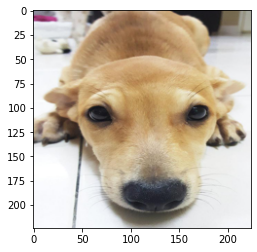

In [28]:
train_dataset.show_image(1)

## Create AverageMeter class to store loss and RMSE values per batch, and define train() function

In [29]:
# stores the frequency of each pawpularity score band 1-10, 11-20, etc.
score_frequencies = np.zeros(shape=(10,))

for i in range(10):
    # extracts all rows of df_train_final (Training set only, not validation) and computes frequency of each score band
    df_intermediate = df_train_final[df_train_final["Pawpularity"] <= 10*(i+1)]
    df_intermediate = df_intermediate[df_intermediate["Pawpularity"] > 10*(i)]
    score_frequencies[i] = len(df_intermediate)

print(score_frequencies)
# weight of class c is the size of largest class divided by the size of class c
factor = np.max(score_frequencies)/torch.from_numpy(score_frequencies) # Make sure no divide by zero!
print(factor)

# free memory
indices = []

# compute RMSE for regression
def compute_rmse(preds, targets):
    return torch.sqrt(torch.mean((preds-targets)**2))

class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

# define training function
def train(model, dataloaders, optimizer, lossfunc, save_name, quiet=False): # made save_name mandatory parameter
    # construct model
    model = model.to(device)

    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    best_model_state = model.state_dict()
    best_epoch = -1
    best_rmse = 9999999

    early_stopping_patience = 4 # added by HCJ
    early_stopping_counter = 0

    epoch_loss = {'train': [], 'val': []}
    epoch_acc = {'train': [], 'val': []}
    epochs = 20

    for epoch in range(epochs):
        accs = AverageMeter()
        losses = AverageMeter()

        for phase in dataloaders.keys():
            if phase == 'train':
                model.train(True)
                torch.set_grad_enabled(True)
            else:
                model.train(False)
                torch.set_grad_enabled(False)

            end = time.time()

            # each for loop returns a dictionary as defined in PawpularityDataset containing the key-value pairs:
            # 'image': the tensor with the normalized image
            # 'features': the matrix of csv features
            # 'targets': the actual pawpularity score
            batches_processed = 0
            for data_dict in tqdm(dataloaders[phase], desc=f'[{phase} {epoch+1}/{epochs}]', leave=False): # sometimes tqdm progress bars are buggy and won't be refreshed from output
                
                inputs = Variable(data_dict['image'].to(device)) # should be a batch_size*3*IMAGE_WIDTH*IMAGE_HEIGHT float tensor
                targets = Variable(data_dict['targets'].to(device)) # should be a batch_size*1 float tensor
                
                # compute output from model, calculate loss via the appropriate criterion, then backpropagate
                outputs = model(inputs) # should be a batch_size*1 float tensor with all values in [0, 1] courtesy of final activation function
                if lossfunc=='MSE':
                    criterion = nn.MSELoss()
                    loss = criterion(outputs, targets) # should be shape=[] float tensor. Use .item() to get its value
                elif lossfunc=='dist-aware-MSE':
                    loss = dist_aware_MSELoss(outputs, targets) # should be shape=[] float tensor. Use .item() to get its value
                
                if phase=='train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                acc = compute_rmse(outputs.data.cpu()*100, targets.data.cpu()*100) # should be shape=[] float tensor denoting rmse between outputs and targets. Note the values here have been scaled back to (0,100) range.

                nsample = inputs.size(0) # should be scalar = batch_size
                accs.update(acc.item(), nsample) # use .item() to extract the value from the tensor
                losses.update(loss.item(), nsample)

                batches_processed += 1

                # periodically clear torch cache 
                if (batches_processed % 10 == 0):
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
             
            # during validation phase, if average computed RMSE less than best RMSE value so far, keep it
            if phase == 'val' and accs.avg < best_rmse:
                best_rmse = accs.avg
                best_epoch = epoch
                best_model_state = model.state_dict()
            elif phase == 'val' and accs.avg >= best_rmse:
                early_stopping_counter += 1
            elif phase == 'train':
                scheduler.step()
            elapsed_time = time.time() - end
            
            # for each epoch and phase, print loss, RMSE, and elapsed time
            if not quiet:
                print(f'[{phase}]\tEpoch: {epoch+1}/{epochs}'+
                    f'\tLoss: {losses.avg:.4f}\tRMSE: {accs.avg:.4f}\tTime: {elapsed_time:.3f}')
            epoch_loss[phase].append(losses.avg)
            epoch_acc[phase].append(accs.avg)
          
        # implement early stopping if RMSE starts to not decrease
        if early_stopping_counter >= early_stopping_patience:
            print(f'[Info] Early stopping occurred at {epoch+1}th epoch')
            break

    print(f'[Info] best RMSE occurred at {best_epoch+1}th epoch')
    if save_name is not None:
        torch.save(best_model_state, save_name)
        print(f'[Info] best model saved to {save_name}')
    return epoch_loss, epoch_acc


[ 331.  814. 2231. 1864. 1083.  583.  346.  225.  137.  298.]
tensor([ 6.7402,  2.7408,  1.0000,  1.1969,  2.0600,  3.8268,  6.4480,  9.9156,
        16.2847,  7.4866], dtype=torch.float64)


## Define modified CNN architecture with 1 output in range $[0,1]$ 

In [30]:
# https://medium.com/analytics-vidhya/how-to-add-additional-layers-in-a-pre-trained-model-using-pytorch-5627002c75a5
class ResNet50Modified(nn.Module):
    def __init__(self):
        super(ResNet50Modified, self).__init__()
        self.model = pretrainedmodels.__dict__['resnet50'](pretrained='imagenet')
        self.classifier_layer = nn.Sequential(
            nn.Linear(2048, 256), # since fc of ResNet50 has 2048 as input
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.Linear(128, 1),
            nn.Sigmoid() # final output layer should be in [0, 1] range. TODO consider other activation funtions here, eg tanh
        )
        
    def forward(self, x):
      batch_size, _, _, _ = x.shape  # taking out batch_size from input image, don't care about the rest
      x = self.model.features(x)
      x = torch.nn.functional.adaptive_avg_pool2d(x,1).reshape(batch_size,-1) # then reshaping the batch_size
      x = self.classifier_layer(x)
      return x

# define the NN model to use
def neuralnet_model():
    model = ResNet50Modified()
    return model

In [31]:
# plot the loss and RMSE for each epoch in each phase
def plot(epoch_loss, epoch_acc, ylim_1, ylim_2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
    #ax1.set_yscale('log')
    #ax1.set_ylim([0, 0.06])
    #ax2.set_ylim([15, 30])
    ax1.set_ylim(ylim_1)
    ax2.set_ylim(ylim_2)
    for phase in ('train', 'val'):
      ax1.plot(range(len(epoch_loss[phase])), epoch_loss[phase], label=(phase + '_loss'))
      ax2.plot(range(len(epoch_acc[phase])), epoch_acc[phase], label=(phase + '_RMSE'))
    ax1.legend(prop={'size': 15})
    ax2.legend(prop={'size': 15})

## Define the dataloaders, optimizer, and train the model

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define dataloaders for train, val sets (also test set, if necessary)
# both 'train_dataset' and 'val_dataset' become PawpularityDataset objects and can be loaded by DataLoader as a "map-style dataset"
dataloaders = {k: torch.utils.data.DataLoader(
                v, batch_size=32, shuffle=(k=='train'),
                num_workers=2, pin_memory=True) for k, v in set1.items()}

In [27]:
cnn_model1 = neuralnet_model()

optimizer1 = optim.SGD(cnn_model1.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

# weights automatically saved after training
b1_epoch_loss, b1_epoch_acc = train(cnn_model1, dataloaders, optimizer1, 'MSE', 'data/cnn_model1.tar')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

[train]	Epoch: 1/20	Loss: 0.0573	RMSE: 23.7296	Time: 731.895


[val]	Epoch: 1/20	Loss: 0.0557	RMSE: 23.4032	Time: 187.828


[train]	Epoch: 2/20	Loss: 0.0440	RMSE: 20.8045	Time: 224.166


[val]	Epoch: 2/20	Loss: 0.0439	RMSE: 20.7759	Time: 43.719


[train]	Epoch: 3/20	Loss: 0.0383	RMSE: 19.4110	Time: 222.566


[val]	Epoch: 3/20	Loss: 0.0388	RMSE: 19.5284	Time: 43.443


[train]	Epoch: 4/20	Loss: 0.0357	RMSE: 18.7475	Time: 224.635


[val]	Epoch: 4/20	Loss: 0.0367	RMSE: 18.9979	Time: 44.210


[train]	Epoch: 5/20	Loss: 0.0336	RMSE: 18.1283	Time: 226.058


[val]	Epoch: 5/20	Loss: 0.0348	RMSE: 18.4483	Time: 43.572


[train]	Epoch: 6/20	Loss: 0.0324	RMSE: 17.7911	Time: 225.864


[val]	Epoch: 6/20	Loss: 0.0339	RMSE: 18.1944	Time: 44.406


[train]	Epoch: 7/20	Loss: 0.0326	RMSE: 17.8376	Time: 224.498


[val]	Epoch: 7/20	Loss: 0.0340	RMSE: 18.2197	Time: 45.634


[train]	Epoch: 8/20	Loss: 0.0323	RMSE: 17.8041	Time: 226.089


[val]	Epoch: 8/20	Loss: 0.0338	RMSE: 18.1822	Time: 44.313


[train]	Epoch: 9/20	Loss: 0.0323	RMSE: 17.7563	Time: 220.952


[val]	Epoch: 9/20	Loss: 0.0338	RMSE: 18.1478	Time: 43.281


[train]	Epoch: 10/20	Loss: 0.0321	RMSE: 17.7441	Time: 224.573


[val]	Epoch: 10/20	Loss: 0.0336	RMSE: 18.1381	Time: 45.058


[train]	Epoch: 11/20	Loss: 0.0317	RMSE: 17.5713	Time: 225.070


[val]	Epoch: 11/20	Loss: 0.0333	RMSE: 17.9965	Time: 43.513


[train]	Epoch: 12/20	Loss: 0.0316	RMSE: 17.5712	Time: 225.266


[val]	Epoch: 12/20	Loss: 0.0333	RMSE: 18.0366	Time: 45.265


[train]	Epoch: 13/20	Loss: 0.0319	RMSE: 17.6300	Time: 234.066


[val]	Epoch: 13/20	Loss: 0.0336	RMSE: 18.0787	Time: 46.413


[train]	Epoch: 14/20	Loss: 0.0316	RMSE: 17.6182	Time: 232.249


[val]	Epoch: 14/20	Loss: 0.0333	RMSE: 18.0506	Time: 45.238
[Info] Early stopping occurred at 14th epoch
[Info] best RMSE occurred at 11th epoch
[Info] best model saved to data/cnn_model1.tar


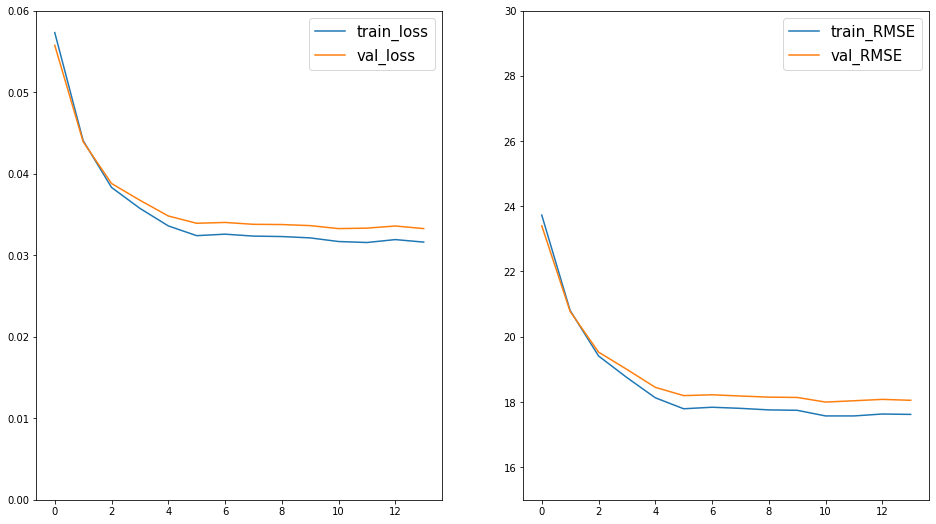

In [28]:
plot(b1_epoch_loss, b1_epoch_acc, [0, 0.06], [15, 30])

In [29]:
from sklearn.manifold import TSNE
import cv2

colors_for_pawpularity = ((0, 0, 255), # red
                              (0, 127, 255), # orange
                              (0, 242, 255), # yellow
                              (0, 255, 187), # light green
                              (28, 165, 37), # dark green
                              (131, 165, 28), # teal
                              (201, 201, 32), # sky blue
                              (201, 94, 32), # deep blue
                              (201, 32, 178), # light purple
                              (96, 13, 87) # purple
                          )

# scales np array to be in [0,1] interval
def scale_to_unit_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

def scale_image(image, max_image_size):
    image_height, image_width, _ = image.shape

    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    image = cv2.resize(image, (image_width, image_height))
    return image

# Modified
def draw_rectangle_by_class(image, label):
    global colors_for_pawpularity
    image_height, image_width, _ = image.shape

    # get the color corresponding to the pawpularity score
    # assume we have 10 bands, 1-10 in 1 band, 2-10 in the next band, etc
    # opencv needs colours to be in 3-tuple BGR format; example: Blue = (255, 0, 0)
    ind = int(label.item()*10)
    if ind==10: # in case model predicted 1
        ind=9
    # for each image, label is a number in [0, 1], so remap it to the corresponding index
    color = colors_for_pawpularity[ind]
    image = cv2.rectangle(image, (0, 0), (image_width - 1, image_height - 1), color=color, thickness=5)

    return image


def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    image_height, image_width, _ = image.shape

    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset

    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset

    # knowing the image center, compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)

    br_x = tl_x + image_width
    br_y = tl_y + image_height

    return tl_x, tl_y, br_x, br_y


def visualize_tsne_images(tx, ty, images, labels, plot_size=1000, max_image_size=100):
    # we'll put the image centers in the central area of the plot
    # and use offsets to make sure the images fit the plot
    offset = max_image_size // 2
    image_centers_area_size = plot_size - 2 * offset

    tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)

    # now we'll put a small copy of every image to its corresponding T-SNE coordinate
    for image_path, label, x, y in tqdm(
            zip(images, labels, tx, ty),
            desc='Building the T-SNE plot',
            total=len(images)
    ):
        image = cv2.imread(image_path)

        # scale the image to put it to the plot
        image = scale_image(image, max_image_size)

        # draw a rectangle with a color corresponding to the image class
        image = draw_rectangle_by_class(image, label)

        # compute the coordinates of the image on the scaled plot visualization
        tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)

        # put the image to its TSNE coordinates using numpy subarray indices
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image

    # change figure height and width
    f = plt.figure()
    f.set_figwidth(30)
    f.set_figheight(30)

    plt.imshow(tsne_plot[:, :, ::-1])
    plt.show()

def visualize_tsne_points(tx, ty, labels):
    global colors_for_pawpularity
    
    # initialize matplotlib plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # for every class, we'll add a scatter plot separately
    for color_enum, label in enumerate(colors_for_pawpularity):
        
        # find the samples of the current class (aka band of pawpularity scores) in the data
        # color_enum starts at 0, l.item() ranges from 0 to 1 so if we multiply by 10 and take floor, we should get the quantile number
        indices = [i for i, l in enumerate(labels) if color_enum == int(l.item()*10)]
        if color_enum==9: # in case label is 1.0
            indices += [i for i, l in enumerate(labels) if 10 == int(l.item()*10)]
          
        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)

        # convert the class color to matplotlib format:
        # BGR -> RGB, divide by 255, convert to np.array
        color = colors_for_pawpularity[color_enum]
        color_np = np.array([color[2], color[1], color[0]], dtype=np.float)/255.0

        # add a scatter plot with the corresponding color and label
        color_label = "Score {} to {}" .format(color_enum*10+1, (color_enum+1)*10)
        ax.scatter(current_tx, current_ty, color=color_np, label=color_label)

    # build a legend using the labels we set previously
    ax.legend(loc='best')

    # change figure height and width    
    fig.set_figwidth(10)
    fig.set_figheight(10)

    # finally, show the plot
    plt.show()


In [30]:
# set random seed
tsne_seed = 19890604
random.seed(tsne_seed)
torch.manual_seed(tsne_seed)
np.random.seed(tsne_seed)

# load saved model from .tar file
if cnn_model1==None:
    print("Loading model weights...")
    cnn_model1 = ResNet50Modified()
    cnn_model1.load_state_dict(torch.load('data/cnn_model1.tar'))

cnn_model1.eval()
cnn_model1.to(device)

features = None
labels = []
image_paths = []

# run model inference and get outputs and plot them
for batch in tqdm(dataloaders['val'], desc='Running the model inference'):
    images = batch['image'].to(device)
    labels += batch['targets']
    image_paths += batch['image_path']
    with torch.no_grad():
        output = cnn_model1(images)
    current_features = output.cpu().numpy()
    if features is None:
        features = current_features
    else:
        features = np.concatenate((features, current_features))

Running the model inference: 100%|██████████| 63/63 [00:45<00:00,  1.40it/s]


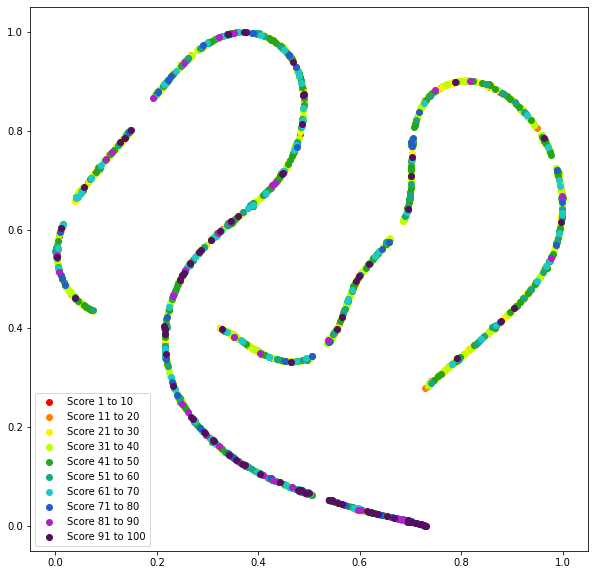

In [31]:
tsne = TSNE(n_components=2, random_state=1984).fit_transform(features)

tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_unit_range(tx)
ty = scale_to_unit_range(ty)
visualize_tsne_points(tx, ty, labels)

Building the T-SNE plot: 100%|██████████| 2000/2000 [00:30<00:00, 65.75it/s]


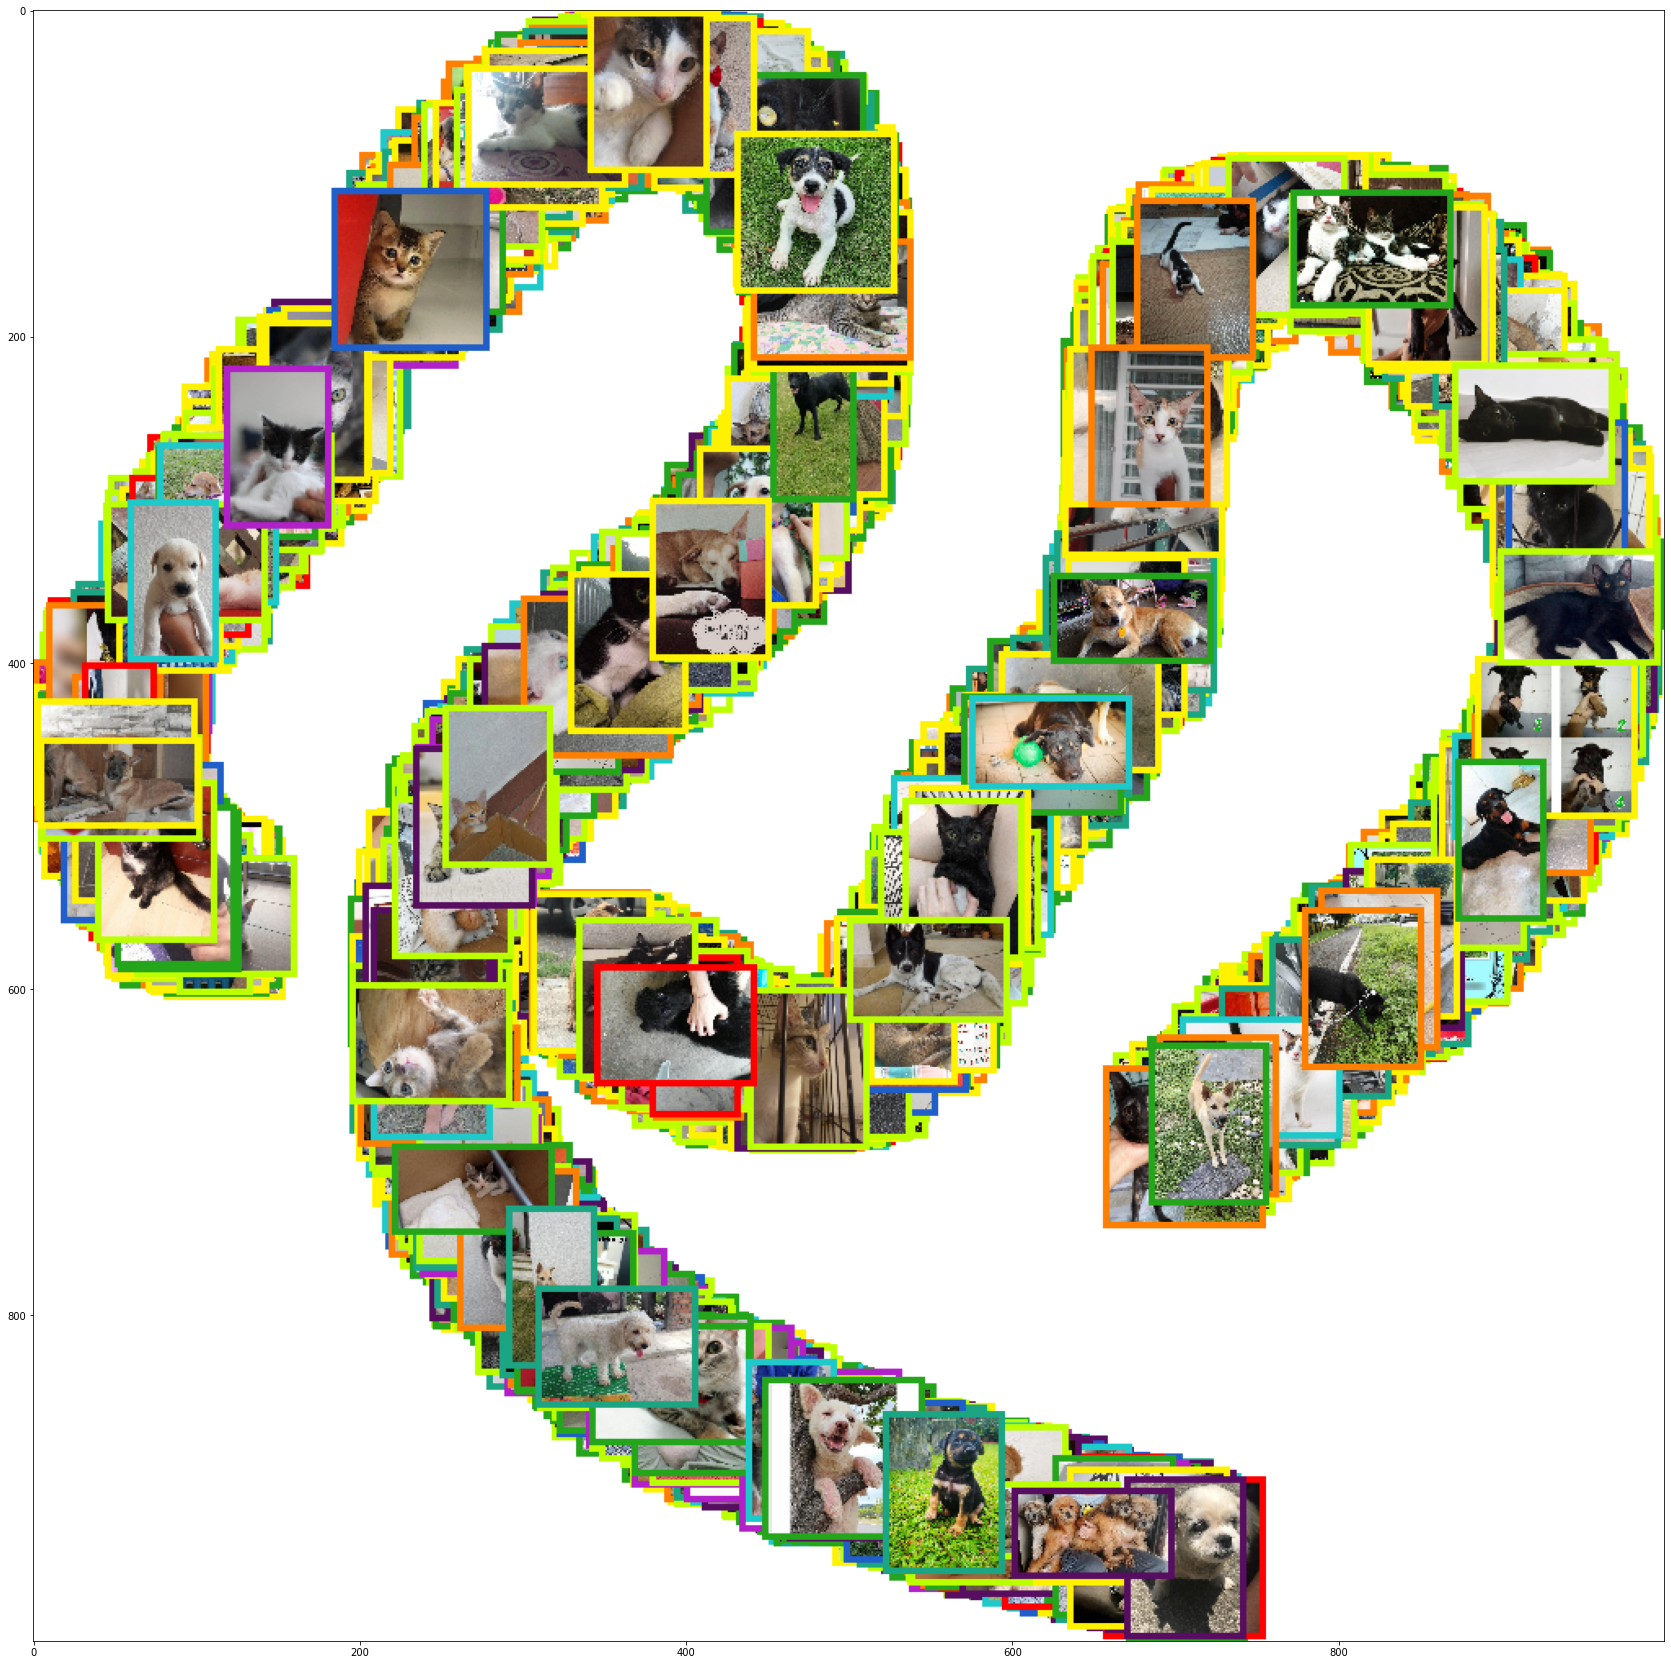

In [32]:
visualize_tsne_images(tx, ty, image_paths, labels, plot_size=1000, max_image_size=100)

In [29]:
# compute a distribution-aware RMSE Loss
# predictions and targets are both in the [0,1] range
def dist_aware_MSELoss(preds, targets):
    global factor
    # https://stackoverflow.com/questions/62484790/why-tensor-clone-detach-is-recommended-when-copying-a-tensor
    targets_as_quantiles = (targets.clone().detach()*10).int().cpu() # convert to [0, 10] range
    targets_as_quantiles[targets_as_quantiles==10] = 9 # replace any 10 (invalid values) with 9
    # convert from int32 datatype back to float datatype
    targets_as_quantiles = targets_as_quantiles.float()
    weight = targets_as_quantiles.apply_(lambda x: factor[int(x)]).to(device)
    # need to move 'targets_as_quantiles' tensor to CPU then 'weight' tensor back to GPU because need to be on same device, and if both on GPU then cannot use apply_ function
    return torch.sqrt(torch.mean(weight * (preds-targets)**2))

#t1 = torch.tensor([40, 19, 16, 28, 25.2, 30.1, 66, 80, 72])/100.0
#t2 = torch.tensor([37, 7, 11, 28, 25, 30, 45, 60, 100])/100.0
#print(dist_aware_MSELoss(t1, t2))
#weight should be tensor([1.1969, 6.7402, 2.7408, 1.0000, 1.0000, 1.1969, 2.0600, 6.4480, 7.4866])
#loss should be tensor(0.3401)

# same model architecture and optimizer, but use weighted MSE as loss function
cnn_model2 = neuralnet_model()

optimizer2 = optim.SGD(cnn_model2.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

# weights automatically saved after training
b2_epoch_loss, b2_epoch_acc = train(cnn_model2, dataloaders, optimizer2, 'dist-aware-MSE', 'data/cnn_model2.tar')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

[train]	Epoch: 1/20	Loss: 0.4448	RMSE: 23.2183	Time: 658.903


[val]	Epoch: 1/20	Loss: 0.4418	RMSE: 23.0172	Time: 157.419


[train]	Epoch: 2/20	Loss: 0.3963	RMSE: 20.9241	Time: 231.529


[val]	Epoch: 2/20	Loss: 0.4030	RMSE: 20.9982	Time: 48.302


[train]	Epoch: 3/20	Loss: 0.3514	RMSE: 19.5417	Time: 232.413


[val]	Epoch: 3/20	Loss: 0.3692	RMSE: 19.9208	Time: 48.741


[train]	Epoch: 4/20	Loss: 0.2946	RMSE: 17.4813	Time: 232.286


[val]	Epoch: 4/20	Loss: 0.3285	RMSE: 18.2062	Time: 48.661


[train]	Epoch: 5/20	Loss: 0.2495	RMSE: 15.5958	Time: 231.951


[val]	Epoch: 5/20	Loss: 0.2959	RMSE: 16.9518	Time: 48.911


[train]	Epoch: 6/20	Loss: 0.2139	RMSE: 13.6309	Time: 233.784


[val]	Epoch: 6/20	Loss: 0.2624	RMSE: 15.3017	Time: 48.910


[train]	Epoch: 7/20	Loss: 0.2004	RMSE: 12.7797	Time: 231.403


[val]	Epoch: 7/20	Loss: 0.2538	RMSE: 14.4174	Time: 48.784


[train]	Epoch: 8/20	Loss: 0.1935	RMSE: 12.4572	Time: 232.950


[val]	Epoch: 8/20	Loss: 0.2475	RMSE: 14.2394	Time: 48.771


[train]	Epoch: 9/20	Loss: 0.1873	RMSE: 12.0924	Time: 231.064


[val]	Epoch: 9/20	Loss: 0.2429	RMSE: 13.9389	Time: 48.319


[train]	Epoch: 10/20	Loss: 0.1845	RMSE: 11.9619	Time: 232.053


[val]	Epoch: 10/20	Loss: 0.2420	RMSE: 13.8262	Time: 48.179


[train]	Epoch: 11/20	Loss: 0.1764	RMSE: 11.5167	Time: 232.674


[val]	Epoch: 11/20	Loss: 0.2342	RMSE: 13.4899	Time: 48.160


[train]	Epoch: 12/20	Loss: 0.1765	RMSE: 11.5542	Time: 231.617


[val]	Epoch: 12/20	Loss: 0.2343	RMSE: 13.5360	Time: 48.193


[train]	Epoch: 13/20	Loss: 0.1772	RMSE: 11.6262	Time: 230.749


[val]	Epoch: 13/20	Loss: 0.2352	RMSE: 13.5792	Time: 47.867


[train]	Epoch: 14/20	Loss: 0.1775	RMSE: 11.6442	Time: 234.213


[val]	Epoch: 14/20	Loss: 0.2371	RMSE: 13.5638	Time: 48.221


[train]	Epoch: 15/20	Loss: 0.1738	RMSE: 11.4339	Time: 230.490


[val]	Epoch: 15/20	Loss: 0.2343	RMSE: 13.3793	Time: 48.338


[train]	Epoch: 16/20	Loss: 0.1781	RMSE: 11.6738	Time: 232.412


[val]	Epoch: 16/20	Loss: 0.2352	RMSE: 13.6475	Time: 48.027
[Info] Early stopping occurred at 16th epoch
[Info] best RMSE occurred at 15th epoch
[Info] best model saved to data/cnn_model2.tar


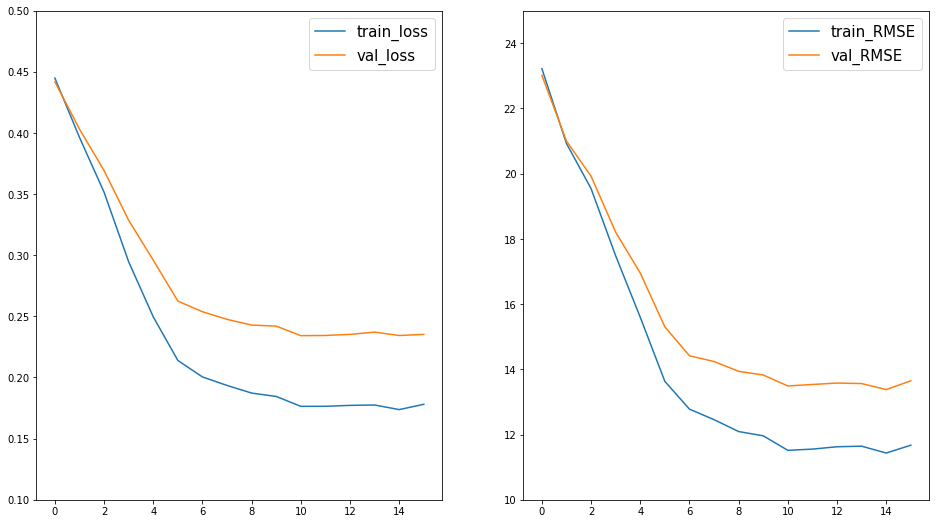

In [30]:
plot(b2_epoch_loss, b2_epoch_acc, [0.1, 0.5], [10, 25])

In [42]:
test_dataset = PawpularityDataset(file_paths=test_file_paths,
                                   csv_features=df_test[metadata_columns].values,
                                   scores=df_train_final["Pawpularity"].values/100.0, # shouldn't be used for test set
                                   transform=transforms.Compose([
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                   ])
                                   )
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                              shuffle=False, num_workers=2,
                                              pin_memory=True) 


cnn_model2.eval()
cnn_model2.to(device)

outputs = None

# run model inference on test set and get outputs
for batch in tqdm(test_dataloader, desc='Running model on test set'):
    images = batch['image'].to(device)
    with torch.no_grad():
        output = cnn_model2(images)
    current_output = output.cpu().numpy()
    if outputs is None:
        outputs = current_output
    else:
        outputs = np.concatenate((outputs, current_output))

sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission["Pawpularity"] = outputs*100 # need round to 4dp?
sample_submission.to_csv("data/submission.csv", index=False)

Running model on test set: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


In [33]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split

In [34]:
AUTOTUNE = tf.data.experimental.AUTOTUNE 

np.random.seed(123)
random.seed(123)
tf.random.set_seed(123)

In [37]:
# Defining functions for reading and augmentation of images
# A seperate function for creating dataset

# Augmenting the image
def image_preprocess(is_labelled):  
    def augment(image):
        image = tf.image.random_flip_left_right(image)
        return image
    
    def can_be_augmented(img, label):
        return augment(img), label
    
    # If record has label, both image and label will be returned
    return can_be_augmented if is_labelled else augment

# Reading and rescaling images
def image_read(is_labelled):
    def decode(path):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, (224, 224))
        image = tf.keras.applications.efficientnet.preprocess_input(image) 
        return image
    
    def can_be_decoded(path, label):
        return decode(path), label

    #   If record has label, both image and label will be returned
    return can_be_decoded if is_labelled else decode


# Creating the dataset
def create_dataset(df, batch_size, is_labelled=False, augment=False, shuffle=False):
    image_read_fn = image_read(is_labelled)
    image_preprocess_fn = image_preprocess(is_labelled)
    
    if is_labelled:
        dataset = tf.data.Dataset.from_tensor_slices((train_file_paths, df_train["Pawpularity"].values))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((test_file_paths))
    
    dataset = dataset.map(image_read_fn, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(image_preprocess_fn, num_parallel_calls=AUTOTUNE) if augment else dataset
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True) if shuffle else dataset
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [38]:
trn = df_train.iloc[:8000]
val = df_train.iloc[8001:]

train = create_dataset(trn, 64, is_labelled=True, augment=True, shuffle=True)
validation = create_dataset(val, 64, is_labelled=True, augment=False, shuffle=False)
test = create_dataset(df_test, 64, is_labelled=False, augment=False, shuffle=False)

In [39]:
img_mod = "data/EfficientNetB0.h5"
efnet = tf.keras.models.load_model(img_mod)

# Layers of efficientnet will not be trained
efnet.trainable = False

ef_model = Sequential([
    Input(shape=(224, 224, 3)),
    efnet,
    BatchNormalization(),
    Dropout(0.2),
    Dense(units=64, activation="relu"),
    Dense(units=1, activation="relu")
])

# Early stopping helps as it stops training if val_loss(validation score) does not decrease.

early_stopping = EarlyStopping(patience = 5,restore_best_weights=True)


lr_schedule = ExponentialDecay(initial_learning_rate=1e-3,
                               decay_steps=100, decay_rate=0.98,staircase=True)

ef_model.compile(loss="mse", 
                 optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule), 
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

predictor = ef_model.fit(train, epochs=20, validation_data=validation, callbacks=[early_stopping])

Epoch 1/20
155/155 [==============================] - 990s 5s/step - loss: 694.3272 - root_mean_squared_error: 26.3501 - val_loss: 591.4866 - val_root_mean_squared_error: 24.3205
Epoch 2/20
155/155 [==============================] - 171s 1s/step - loss: 375.4641 - root_mean_squared_error: 19.3769 - val_loss: 371.3575 - val_root_mean_squared_error: 19.2706
Epoch 3/20
155/155 [==============================] - 173s 1s/step - loss: 357.4771 - root_mean_squared_error: 18.9071 - val_loss: 326.1171 - val_root_mean_squared_error: 18.0587
Epoch 4/20
155/155 [==============================] - 174s 1s/step - loss: 348.6254 - root_mean_squared_error: 18.6715 - val_loss: 317.2854 - val_root_mean_squared_error: 17.8125
Epoch 5/20
155/155 [==============================] - 173s 1s/step - loss: 338.1941 - root_mean_squared_error: 18.3901 - val_loss: 307.8549 - val_root_mean_squared_error: 17.5458
Epoch 6/20
155/155 [==============================] - 172s 1s/step - loss: 330.9330 - root_mean_squared_e

In [41]:
tf.keras.models.save_model(ef_model, 'data/efficientnet_model')

INFO:tensorflow:Assets written to: data/efficientnet_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
